## Daily Work Flow Tracker

### Setup

1. setup the jupyter system in the virtual machine 
     a. set-up the virtual machine, run the below command in any terminal ( prefer gitbash)
        ssh root@VM_IP.Address
        enter your ssh credentials 
     b. In your virtual machine terminal run the below command
        ssh -i ~/.ssh/public_key(enter your ssh public key id)  -L 7777:localhost:8888 root@VM_IP_address
        jupyter notebook --no-browser --port=8888 --ip=0.0.0.0 --allow-root
     c. Open browser and type localhost:7777 ( which is passed earlier during initialization)

2. make directory for the project either directly from the jupyter notebook 
    or through terminal as cd path/where/main folder / to be located.. then
    mkdir ~/NameOfDirectory

3. clone the git repository of the project in the working directory
    git clone https://git.tu-berlin.de/rsim/hsi-compression.git

4. Building the datasets for the project
    a. If the datasets are in local device then transfer it to virtual machine working directory using scp 
        $ scp -r path to/transfering/local directory root@VM_IP_Address:~/project/working directory/dataset
    b. fetching the dataset directly from the website if permission is granted
        # Step 1: Download the dataset
        wget -O dataset.zip https:link

        # Step 2: Extract the contents of the downloaded file
        unzip dataset.zip -d /path/to/extract/

5. Primarilary set-up is complete

### Dataset Directory Visualization

In [3]:
import os
import pandas as pd
from tqdm import tqdm

# Define the base directory
base_dir = "datasets/hyspecnet-11k/patches"

# List to hold file information
file_data = []

# Count the total number of files for progress tracking
total_files = sum(len(files) for _, _, files in os.walk(base_dir))

# Walk through the dataset directory with a progress bar
with tqdm(total=total_files, desc="Scanning Files", unit="file") as pbar:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".tif") or file.endswith(".npy"):
                file_path = os.path.join(root, file)
                file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
                file_extension = os.path.splitext(file)[-1]
                file_data.append([root, file, file_extension, file_size])
            pbar.update(1)

# Create a DataFrame for better visualization
df = pd.DataFrame(file_data, columns=["Directory", "Filename", "Extension", "Size (MB)"])

# Display the DataFrame
print("\nDataset Overview:")
print(df.head())  # Display the first few rows for a quick overview


Scanning Files: 100%|██████████| 17098/17098 [00:00<00:00, 283313.16file/s]


Dataset Overview:
                                           Directory  \
0  datasets/hyspecnet-11k/patches/tile_003/tile_0...   
1  datasets/hyspecnet-11k/patches/tile_003/tile_0...   
2  datasets/hyspecnet-11k/patches/tile_003/tile_0...   
3  datasets/hyspecnet-11k/patches/tile_003/tile_0...   
4  datasets/hyspecnet-11k/patches/tile_003/tile_0...   

                                            Filename Extension  Size (MB)  
0  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
1  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
2  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
3  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
4  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  


### Data Visualization

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_022/tile_022-patch_46/ENMAP01-____L2A-DT0000004990_20221104T023111Z_010_V010110_20221118T144901Z-Y09401067_X04350562-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


/root/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


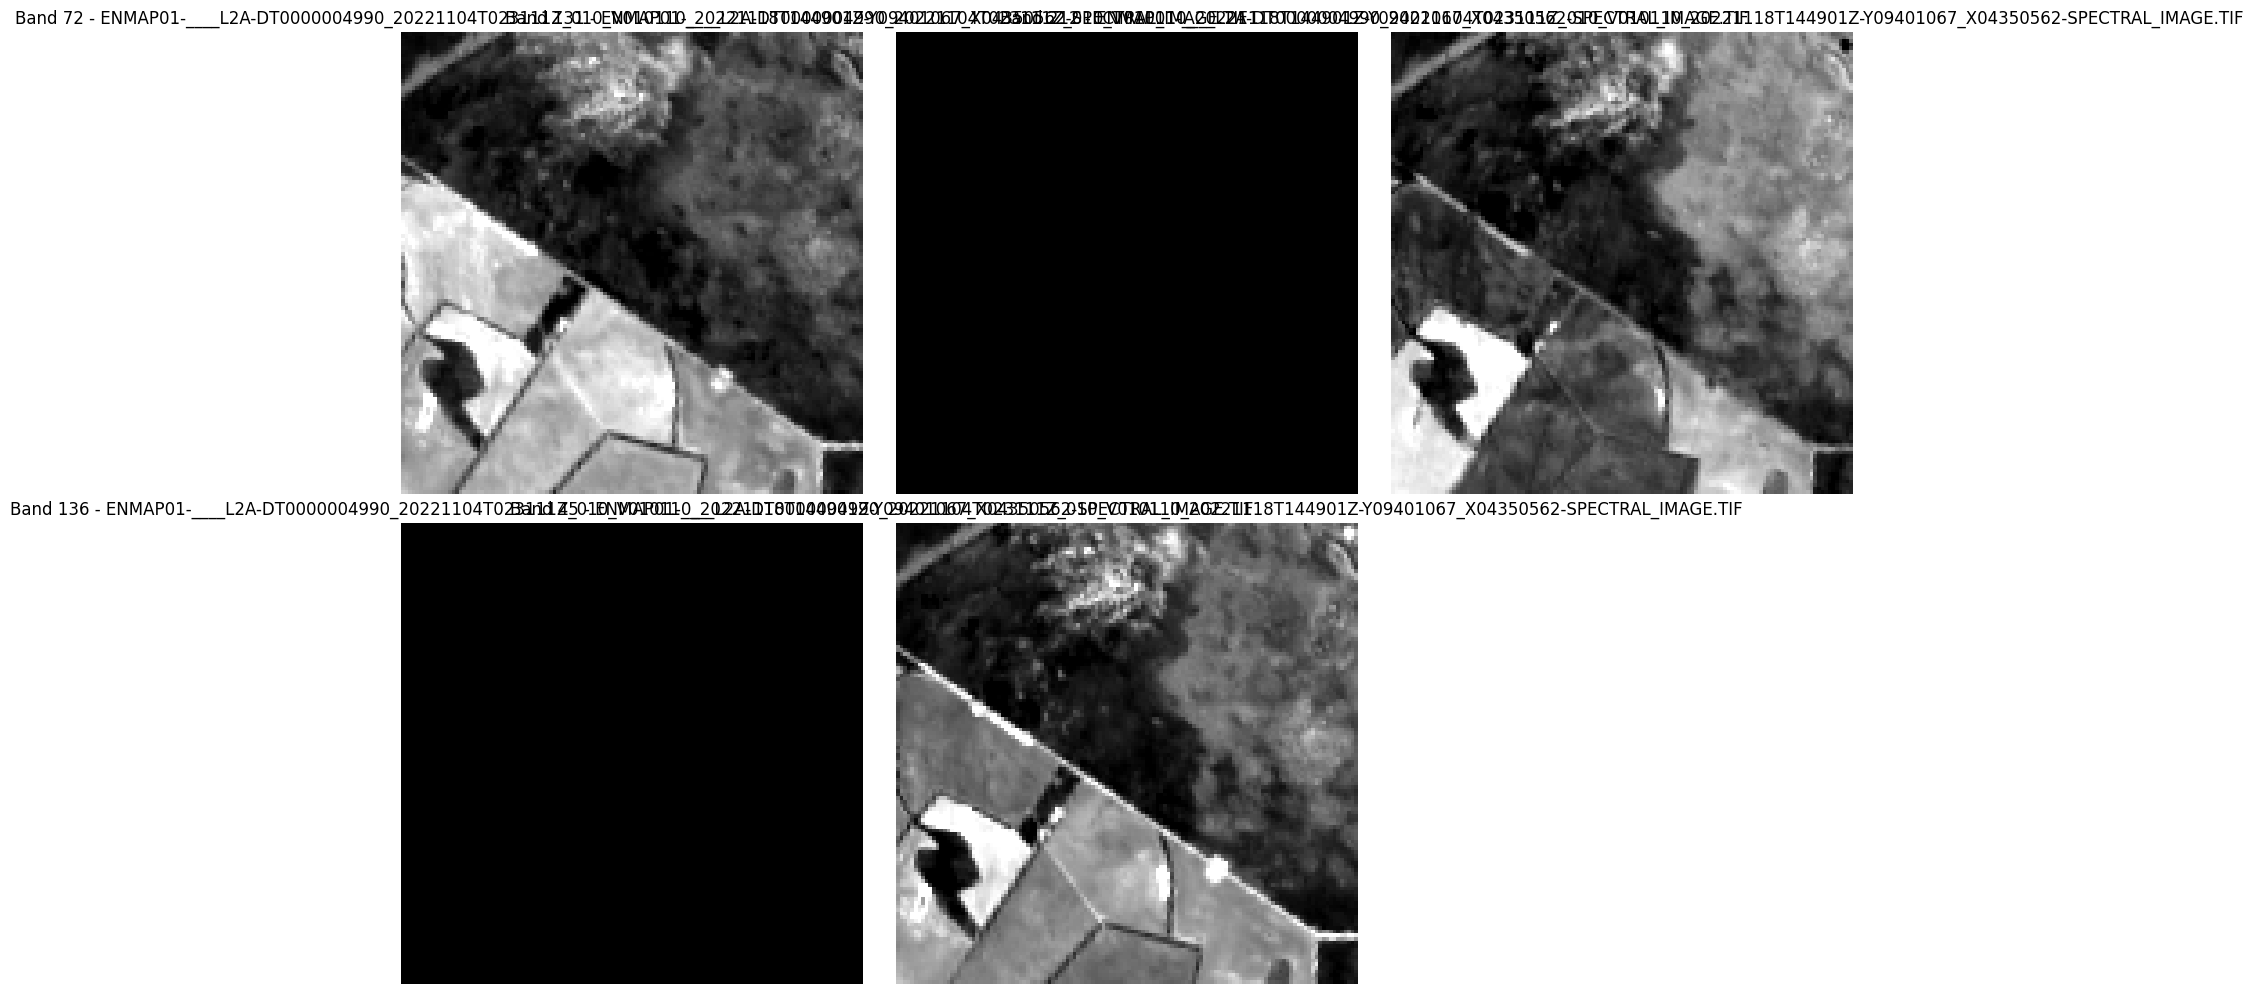

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_001/tile_001-patch_10/ENMAP01-____L2A-DT0000004990_20221104T023111Z_010_V010110_20221118T144901Z-Y09401067_X05630690-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


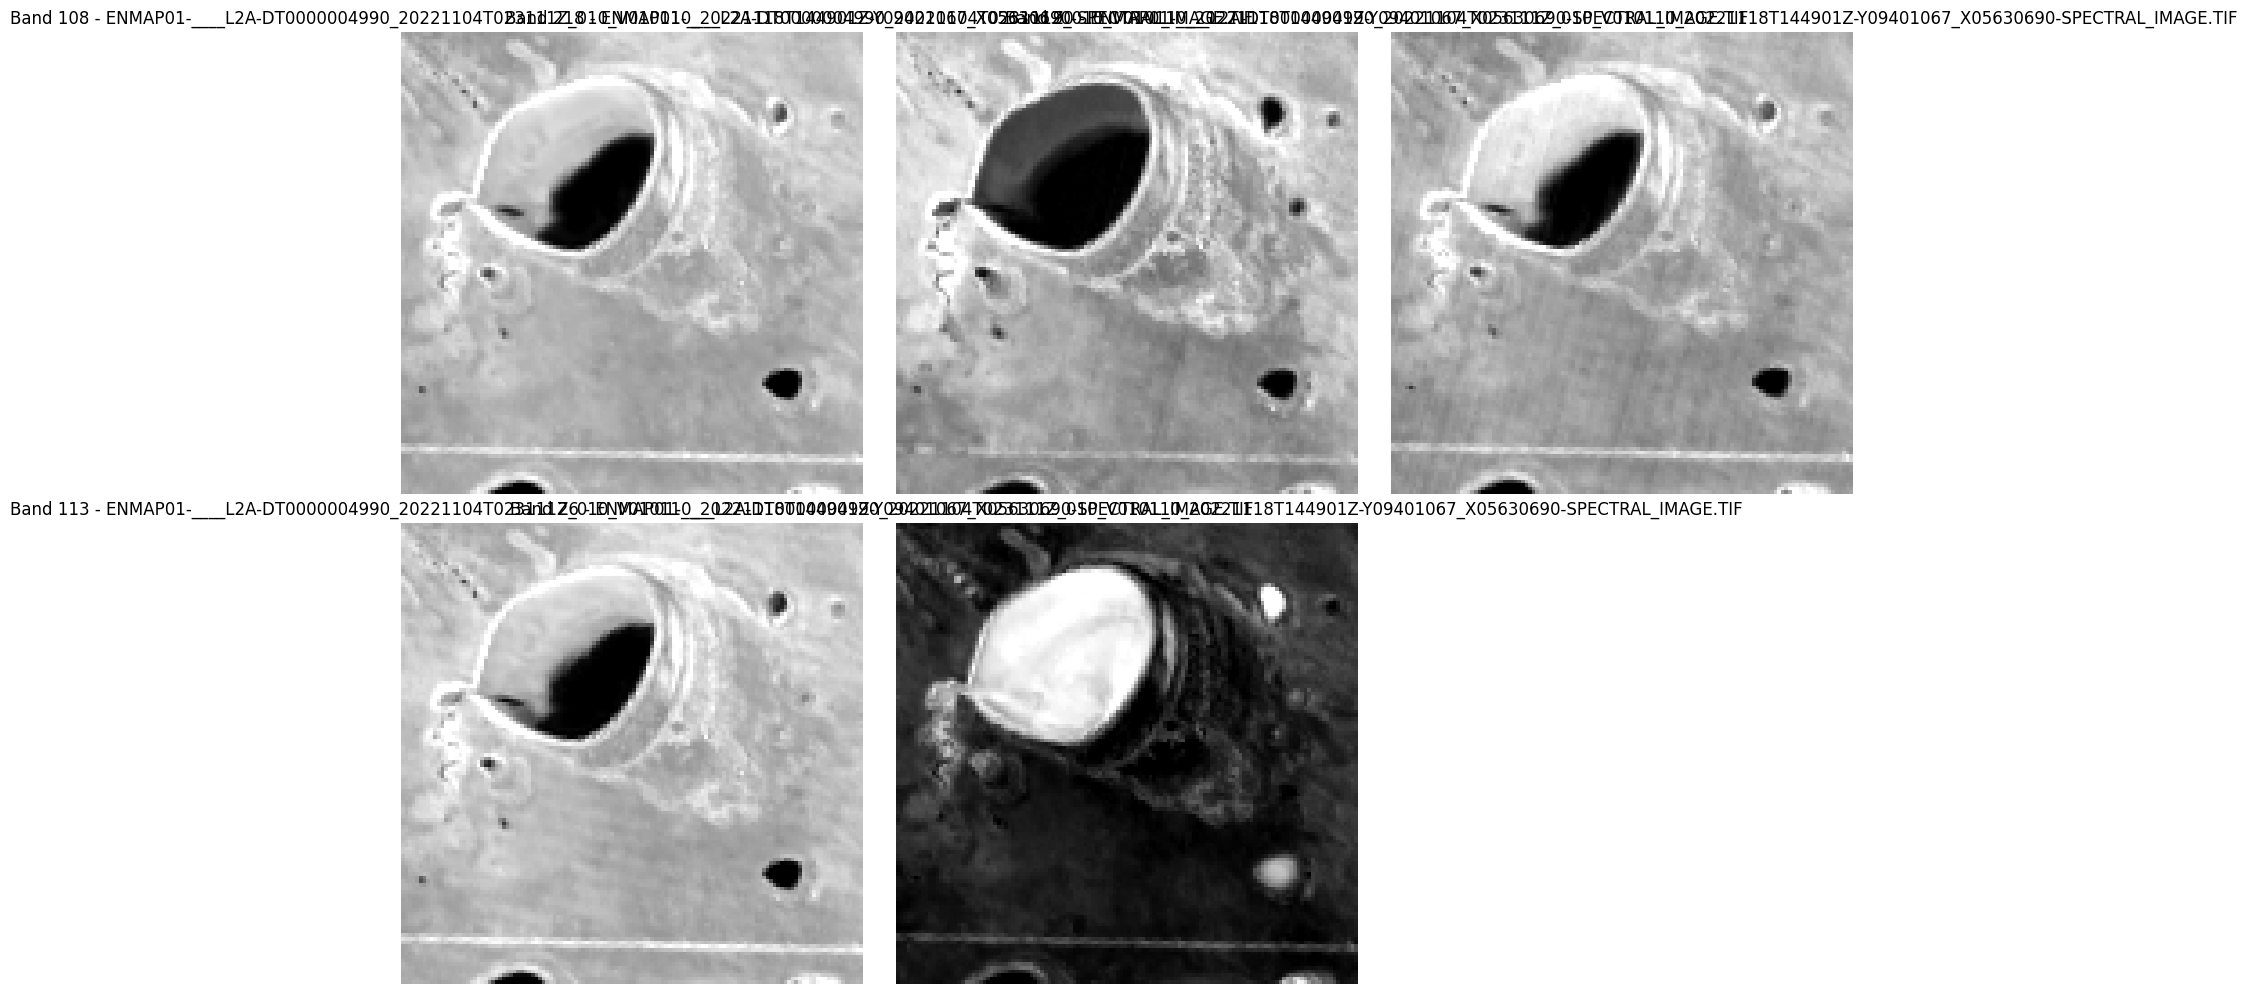

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_28/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y05700697_X07980925-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


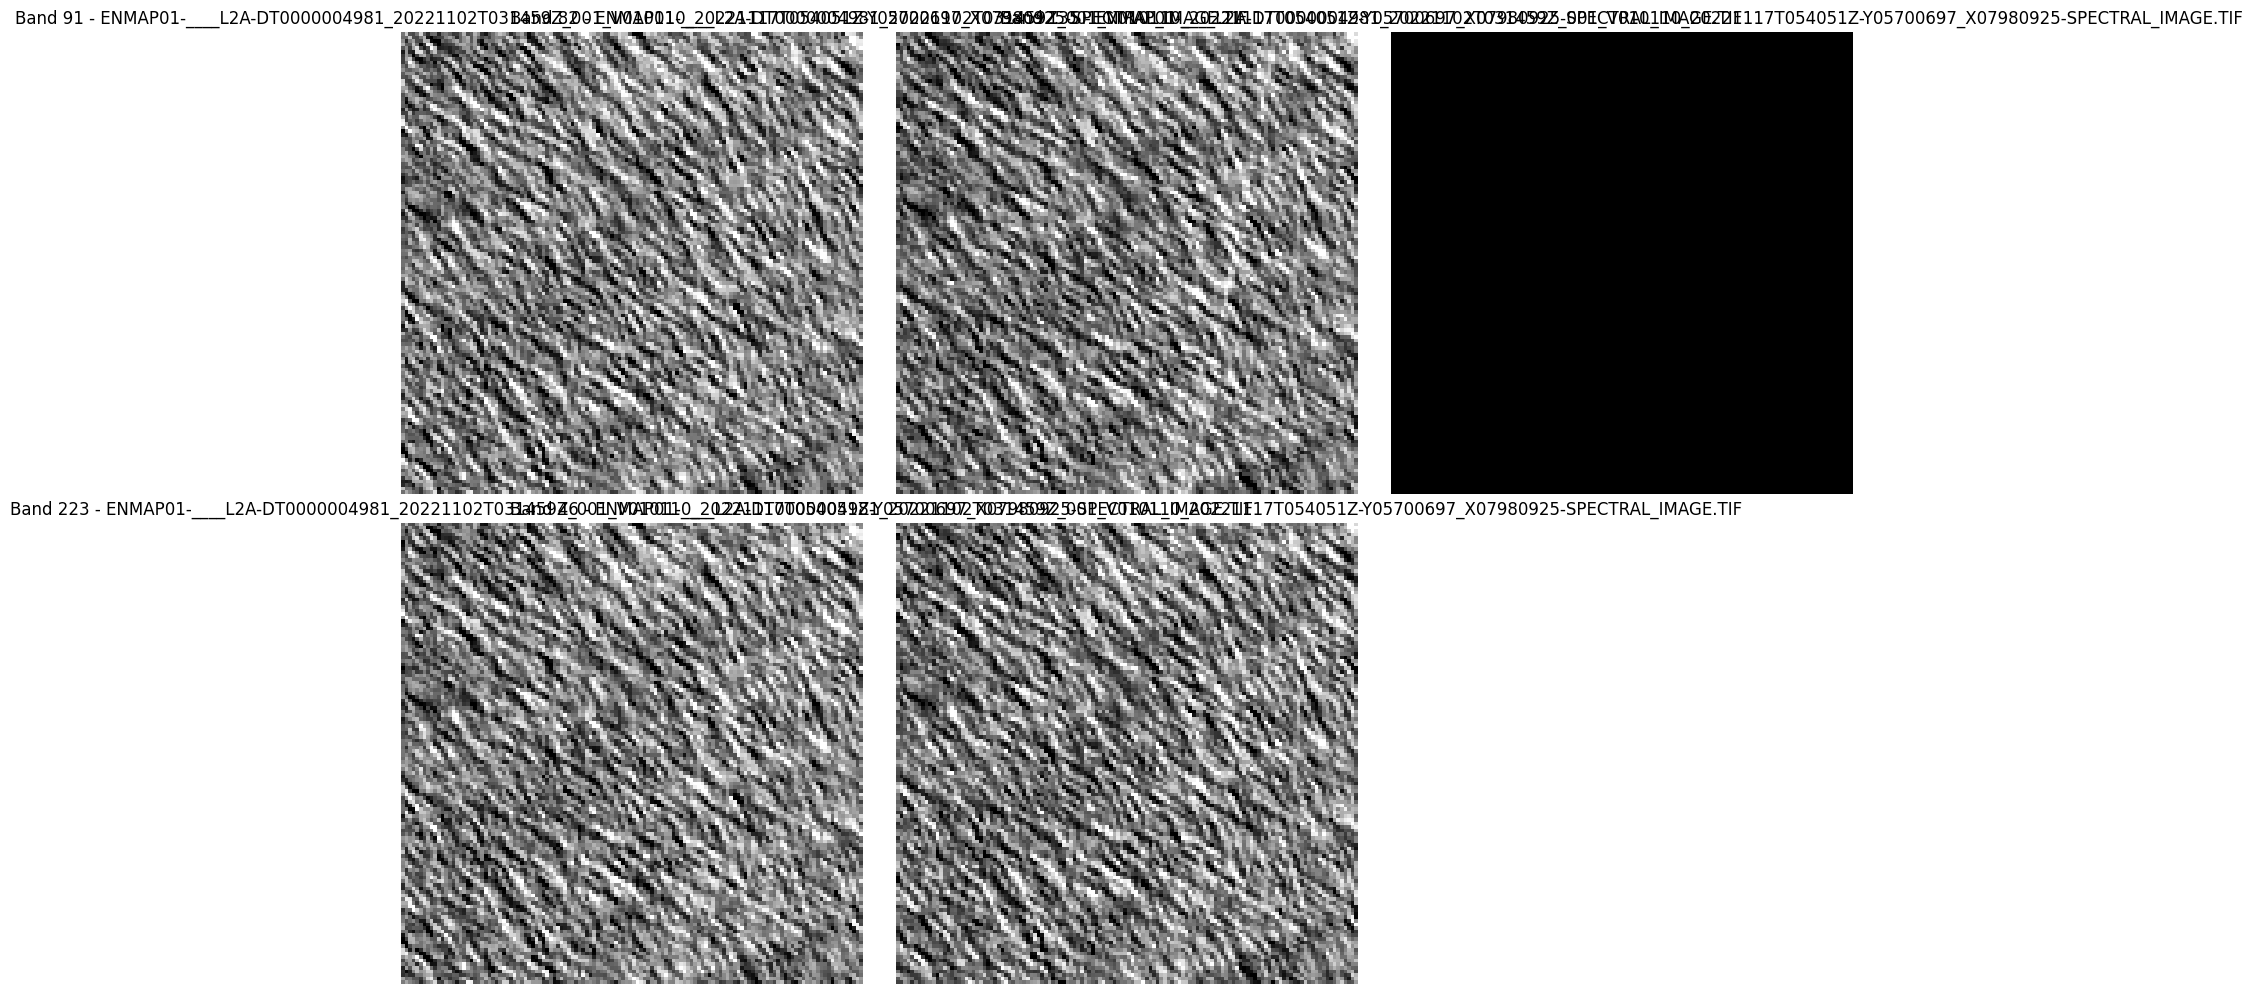

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_014/tile_014-patch_34/ENMAP01-____L2A-DT0000004990_20221104T023036Z_002_V010110_20221116T121134Z-Y06620789_X06690796-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


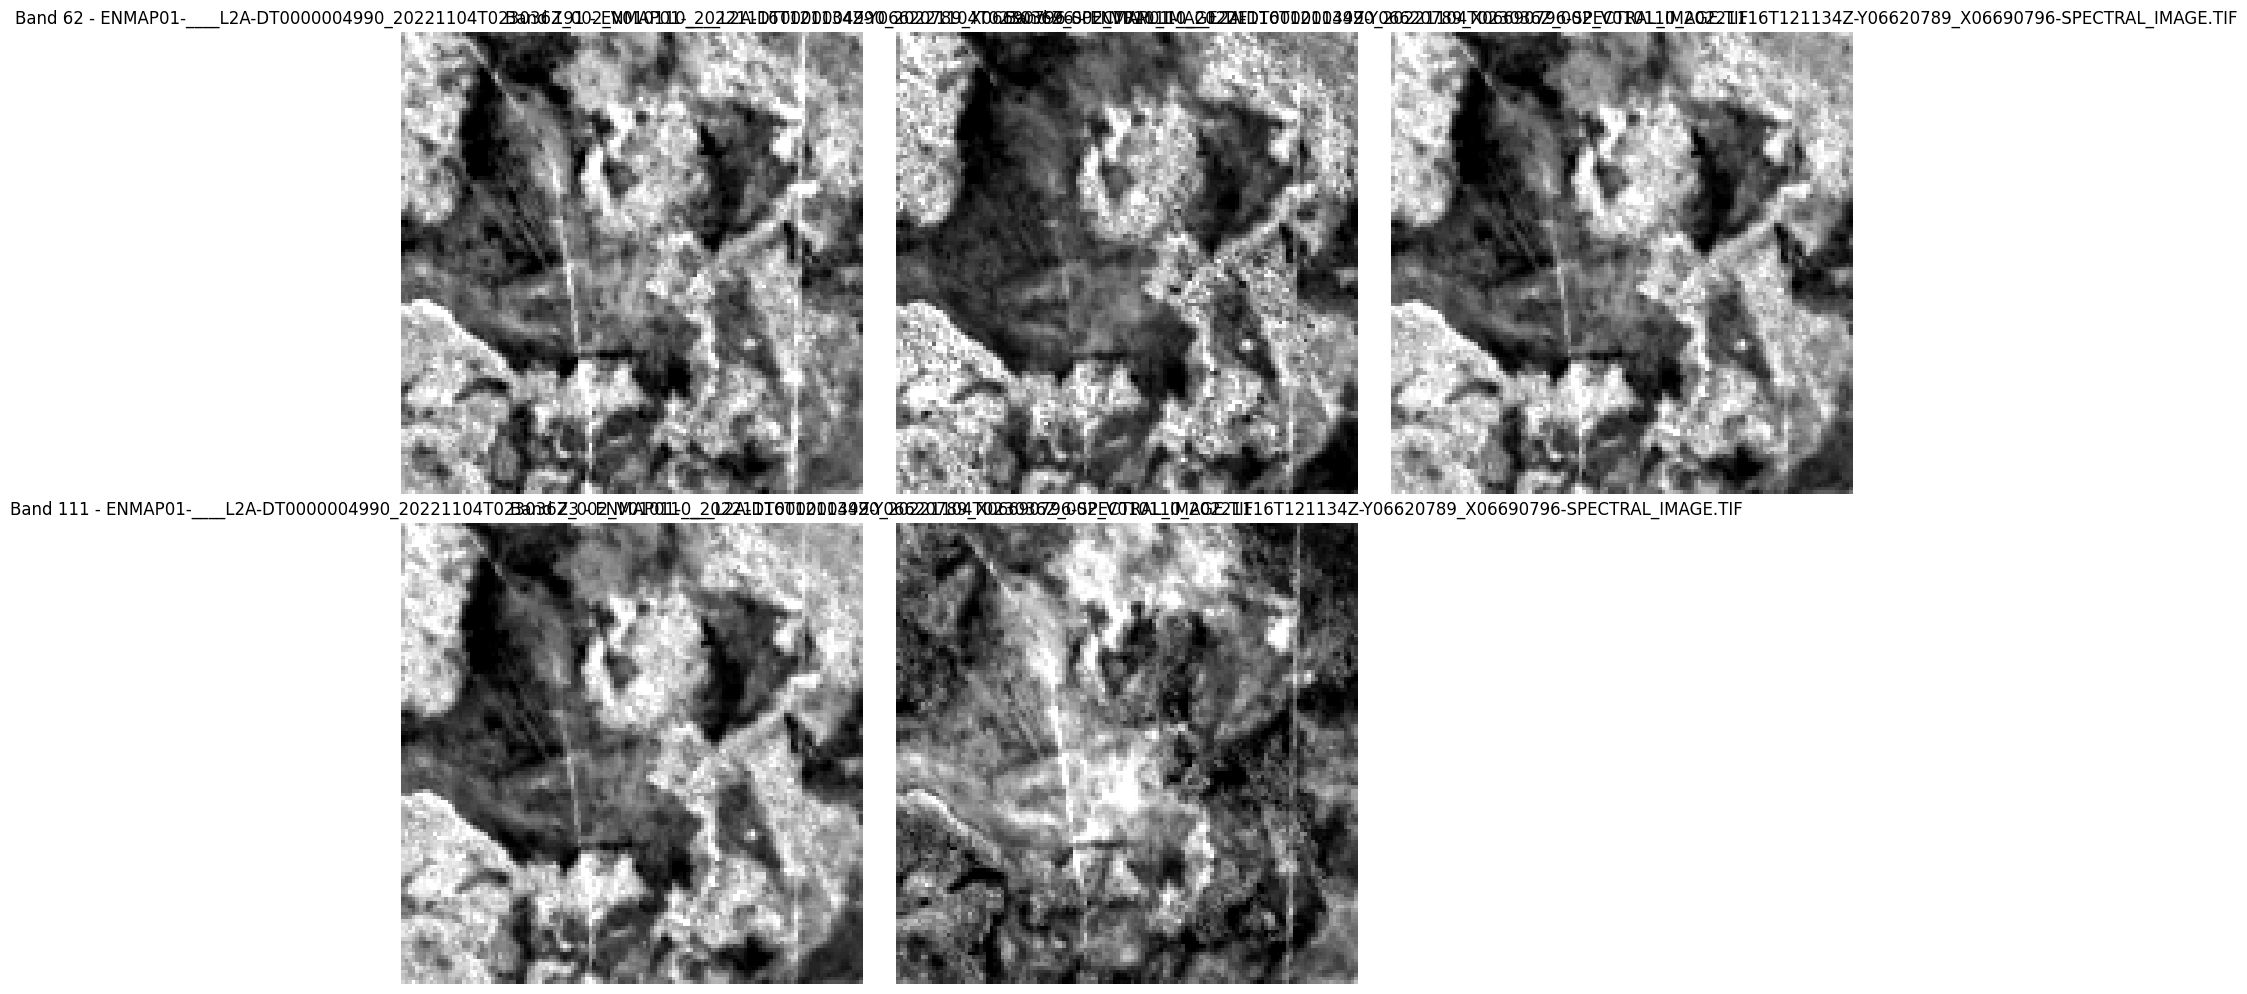

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_012/tile_012-patch_07/ENMAP01-____L2A-DT0000004981_20221102T031548Z_012_V010110_20221118T144902Z-Y02660393_X01740301-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


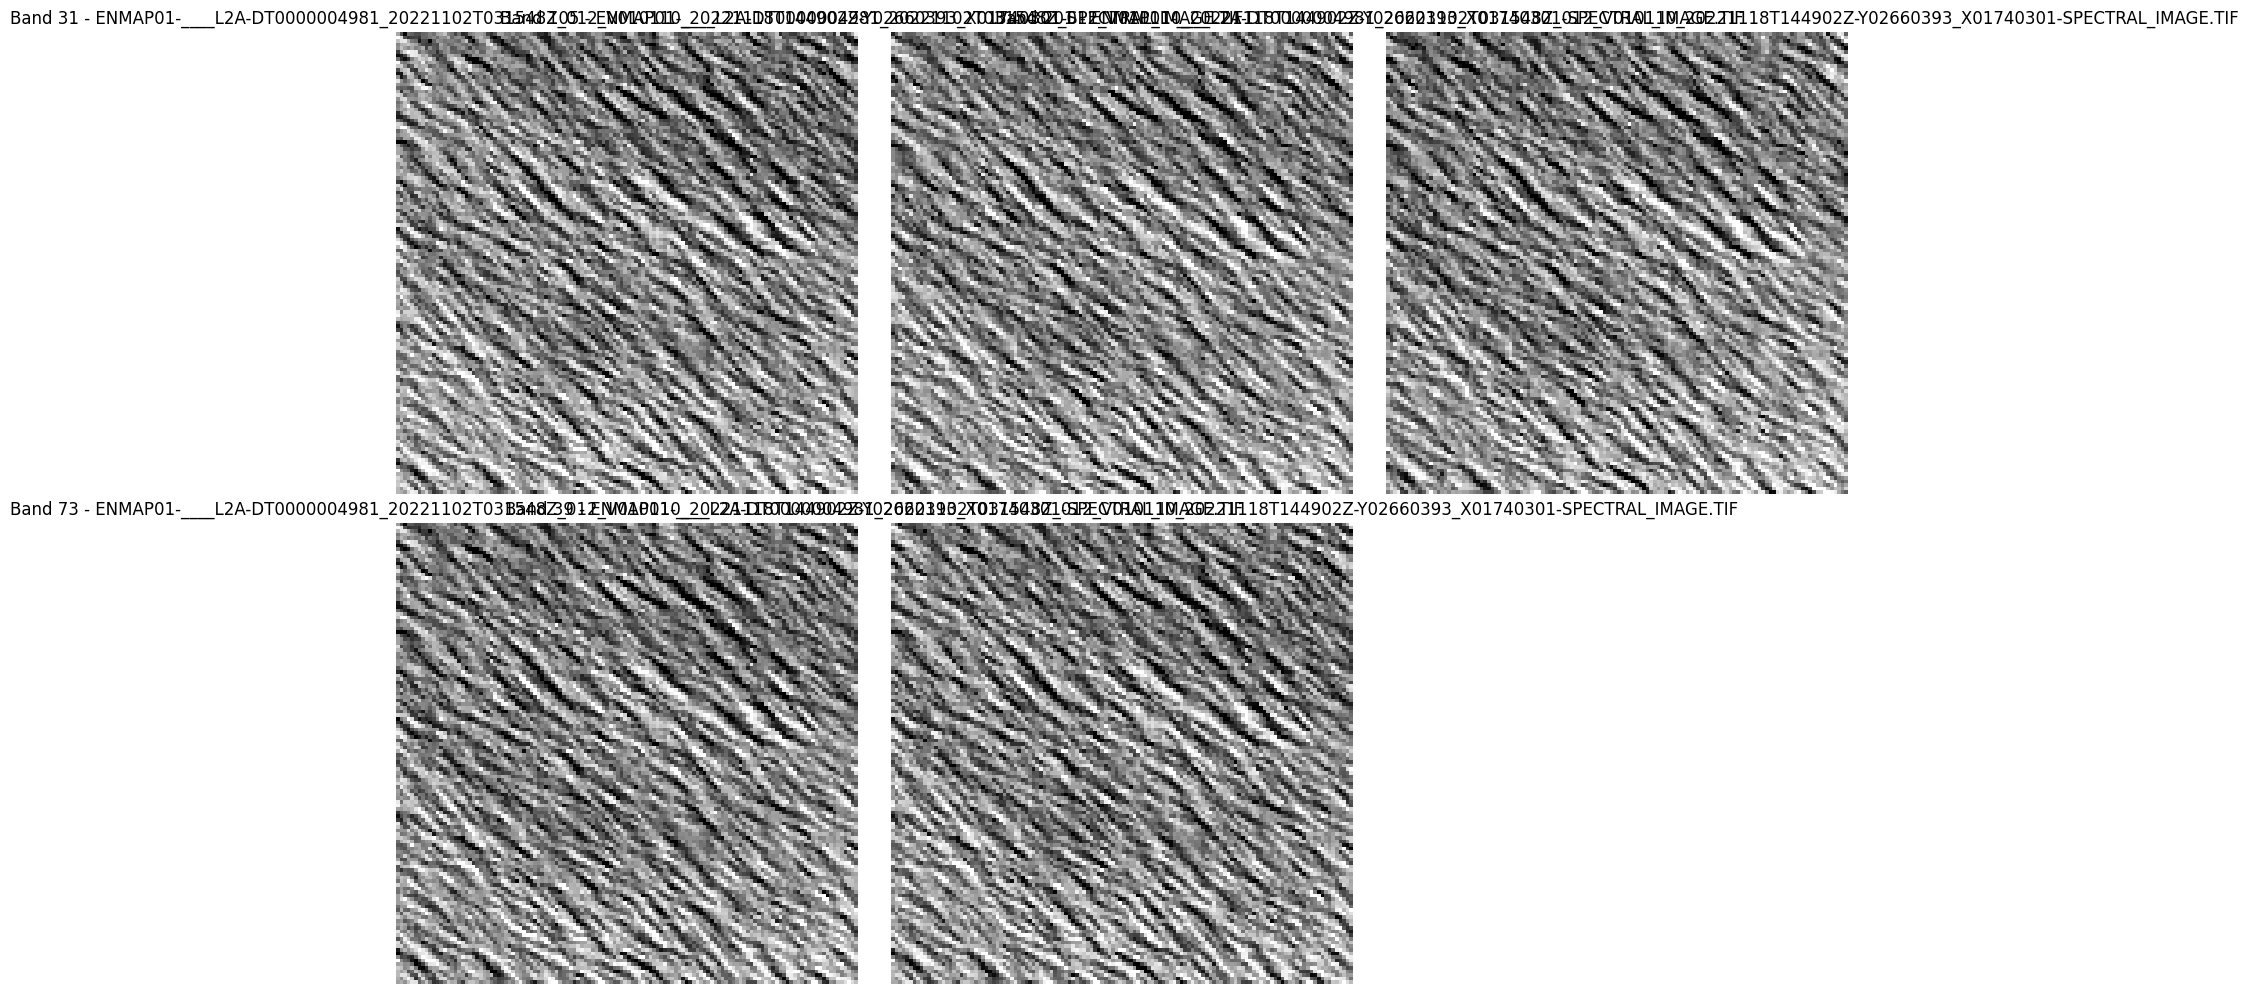

In [2]:
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define the base directory (update if needed)
base_dir = "/root/hsi-compression/datasets/hyspecnet-11k/patches"
tif_files = []

# Helper function to check if the image is blank or mostly masked
def is_mostly_blank(image):
    non_zero_count = np.count_nonzero(image)
    total_count = image.size
    return (non_zero_count / total_count) < 0.05  # Less than 5% non-zero pixels

# Helper function to normalize the image using contrast stretching
def enhance_image(image):
    p2, p98 = np.nanpercentile(image, (2, 98))
    img_stretched = np.clip((image - p2) / (p98 - p2), 0, 1)
    img_stretched = np.nan_to_num(img_stretched, nan=0)
    return img_stretched

# Collect all valid .tif files
print("Collecting .tif files...")
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(".tif") or file.lower().endswith(".tiff"):
            if "QL" in file.upper() or "MASK" in file.upper() or "HAZE" in file.upper():
                continue
            tif_files.append(os.path.join(root, file))

# Select 5 random .tif files
if len(tif_files) < 5:
    print("Not enough .tif files found. Displaying all available files.")
    selected_files = tif_files
else:
    selected_files = random.sample(tif_files, 5)

# Display 5 different bands for each selected image
for file_path in selected_files:
    print(f"Processing file: {file_path}")

    try:
        with rasterio.open(file_path) as src:
            img = src.read()
            no_data_value = src.nodata

            # Replace no-data values with NaN
            if no_data_value is not None:
                img = np.where(img == no_data_value, np.nan, img)

            # Skip mostly blank images
            if is_mostly_blank(img):
                print(f"Skipping mostly blank image: {file_path}")
                continue

            num_bands = img.shape[0]
            print(f"Number of bands in image: {num_bands}")

            # Randomly select 5 unique bands to display
            if num_bands < 5:
                selected_bands = list(range(num_bands))  # Use all available bands if fewer than 5
            else:
                selected_bands = random.sample(range(num_bands), 5)

            # Plot the selected bands
            plt.figure(figsize=(15, 10))
            for i, band in enumerate(selected_bands):
                img_enhanced = enhance_image(img[band])

                plt.subplot(2, 3, i + 1)
                plt.imshow(img_enhanced, cmap='gray')
                plt.title(f"Band {band + 1} - {os.path.basename(file_path)}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


The images appear in grayscale because hyperspectral images do not typically contain inherent color information like regular RGB images. Instead, hyperspectral data consists of numerous spectral bands that correspond to different wavelengths of light, often extending beyond the visible spectrum (including near-infrared and shortwave infrared wavelengths).
Hyperspectral images can have dozens to hundreds of spectral bands, capturing data across a wide range of wavelengths (e.g., 400 nm to 2500 nm).
Only three specific bands (Red, Green, Blue) fall within the visible light spectrum (approximately 400 nm to 700 nm). The rest are outside the visible range (e.g., near-infrared), and we cannot perceive these as colors.

Code to Create and Display a False-Color Composite

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_022/tile_022-patch_34/ENMAP01-____L2A-DT0000004990_20221104T023111Z_010_V010110_20221118T144901Z-Y06840811_X06910818-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


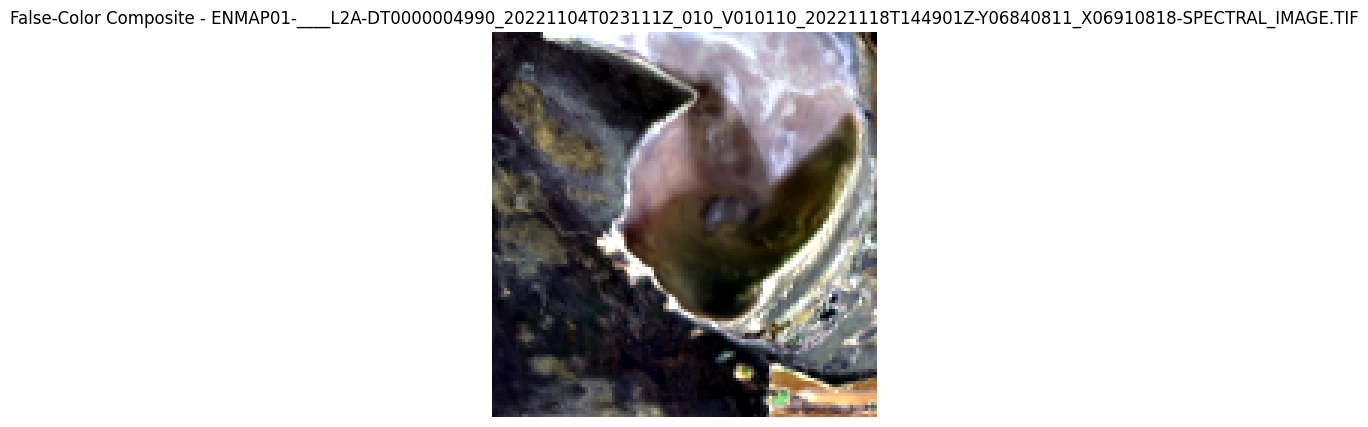

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_002/tile_002-patch_50/ENMAP01-____L2A-DT0000004990_20221104T023116Z_011_V010110_20221119T005504Z-Y09431070_X08190946-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


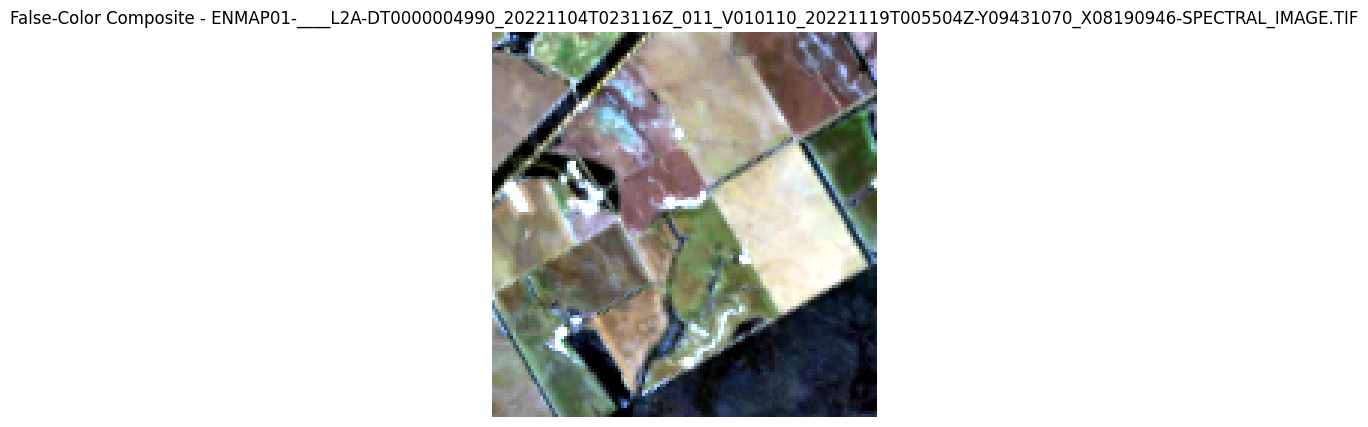

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_021/tile_021-patch_03/ENMAP01-____L2A-DT0000004990_20221104T023107Z_009_V010110_20221118T181236Z-Y01730300_X04360563-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


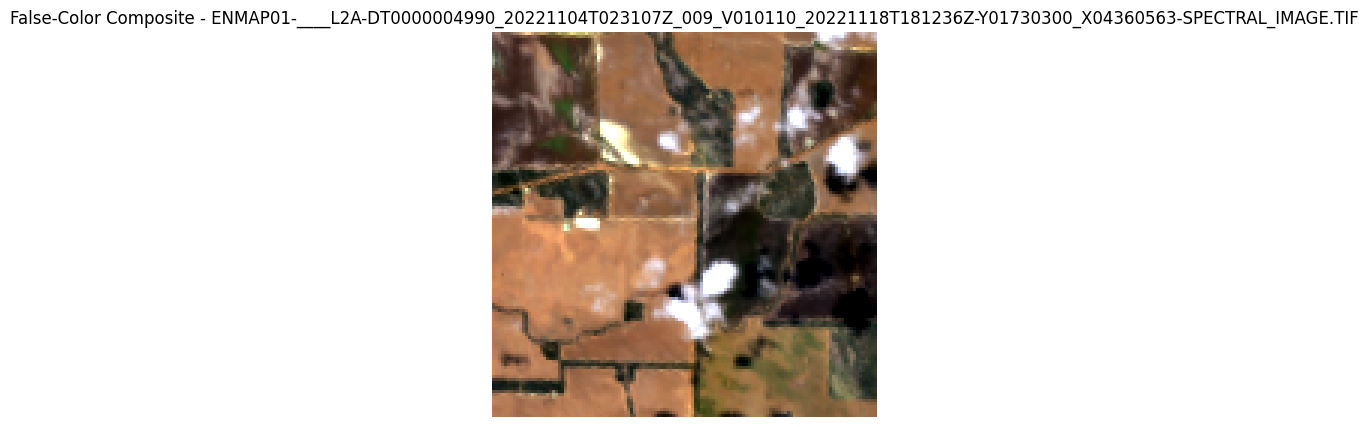

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_022/tile_022-patch_32/ENMAP01-____L2A-DT0000004990_20221104T023111Z_010_V010110_20221118T144901Z-Y06840811_X04350562-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


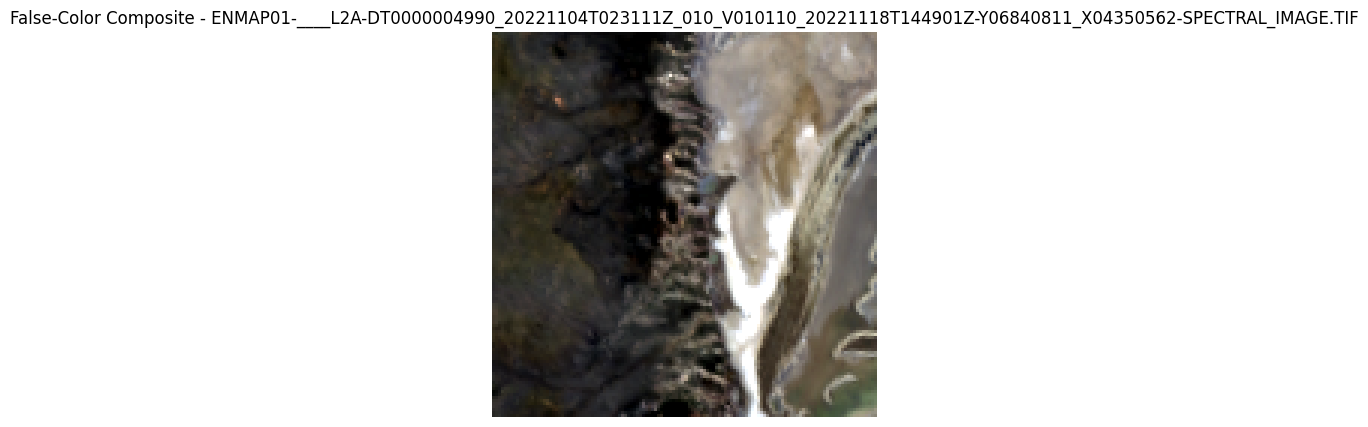

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_022/tile_022-patch_44/ENMAP01-____L2A-DT0000004990_20221104T023111Z_010_V010110_20221118T144901Z-Y08120939_X09471074-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


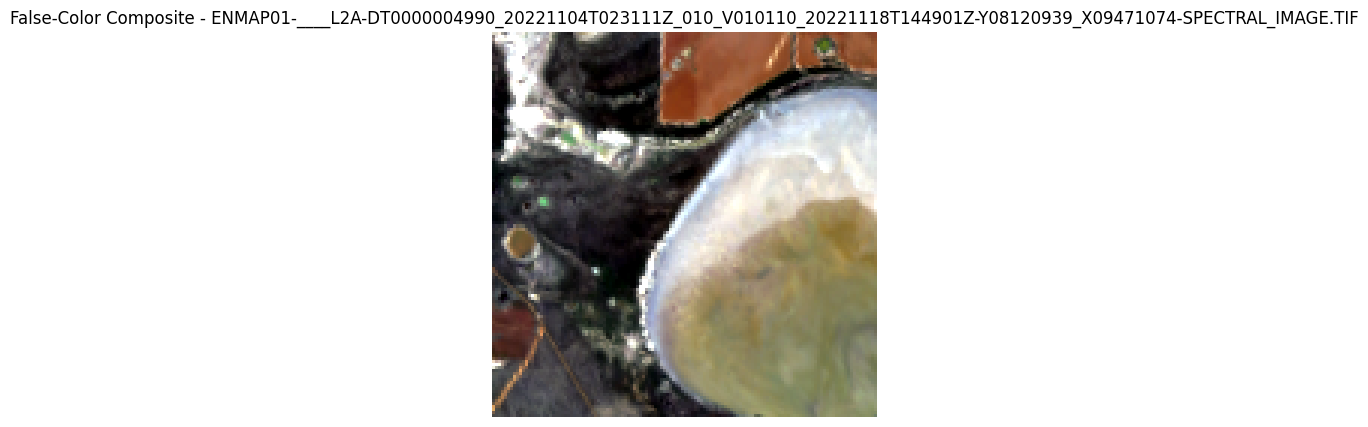

In [5]:
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define the base directory (update if needed)
base_dir = "/root/hsi-compression/datasets/hyspecnet-11k/patches"
tif_files = []

# Collect all valid .tif files
print("Collecting .tif files...")
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(".tif") or file.lower().endswith(".tiff"):
            if "QL" in file.upper() or "MASK" in file.upper() or "HAZE" in file.upper():
                continue
            tif_files.append(os.path.join(root, file))

# Select 5 random .tif files
if len(tif_files) < 5:
    print("Not enough .tif files found. Displaying all available files.")
    selected_files = tif_files
else:
    selected_files = random.sample(tif_files, 5)

# Display a false-color composite for each selected image
for file_path in selected_files:
    print(f"Processing file: {file_path}")

    try:
        with rasterio.open(file_path) as src:
            img = src.read()
            no_data_value = src.nodata

            # Replace no-data values with NaN
            if no_data_value is not None:
                img = np.where(img == no_data_value, np.nan, img)

            num_bands = img.shape[0]
            print(f"Number of bands in image: {num_bands}")

            # Check if there are enough bands for a false-color composite
            if num_bands < 50:
                print(f"Not enough bands for false-color composite. Skipping file: {file_path}")
                continue

            # Select bands for false-color composite
            red_band = img[49]  # Near-infrared (Band 50)
            green_band = img[29]  # Red (Band 30)
            blue_band = img[9]   # Green (Band 10)

            # Normalize the bands using histogram stretching
            def normalize_band(band):
                p2, p98 = np.nanpercentile(band, (2, 98))
                return np.clip((band - p2) / (p98 - p2), 0, 1)

            red = normalize_band(red_band)
            green = normalize_band(green_band)
            blue = normalize_band(blue_band)

            # Create an RGB composite
            rgb_image = np.dstack((red, green, blue))

            # Display the false-color composite
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_image)
            plt.title(f"False-Color Composite - {os.path.basename(file_path)}")
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


### Converting SPECTRAL_IMAGE.TIF to DATA.npy for testing

The *-DATA.npy files have to be generated by running the tif_to_npy.py 
In the *-DATA.npy files the number of bands is reduced from 224 to 202 by removing bands [127 – 141] and [161 – 167] that are affected by strong water vapor absorption. The data is clipped and rescaled to the range [0 – 1] using min-max normalization. Furthermore, the data is converted to float32.

### Test Run

In [9]:
!bash test.sh



Loading ./results/weights/cae1d_8bpppc.pth.tar
/root/hsi-compression/utils/checkpoint.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_

In [10]:
import os

output_dir = "results/tests/"
files = os.listdir(output_dir)
print("Files in results/test/:", files)


Files in results/test/: ['.gitkeep', 'weights.json', '.ipynb_checkpoints']


In [14]:
import os
import json

json_file = "results/tests/weights.json"

if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Function to print JSON line by line
    def print_json_line_by_line(obj, indent=0):
        if isinstance(obj, dict):
            for key, value in obj.items():
                print(" " * indent + f"{key}:")
                print_json_line_by_line(value, indent + 2)
        elif isinstance(obj, list):
            for index, item in enumerate(obj):
                print(" " * indent + f"- Item {index + 1}:")
                print_json_line_by_line(item, indent + 2)
        else:
            print(" " * indent + str(obj))

    # Print the JSON content line by line
    print_json_line_by_line(data)
else:
    print(f"File not found: {json_file}")



name:
  cae1d
description:
  Test
results:
  bpppc:
    - Item 1:
      8.079207920792074
  psnr:
    - Item 1:
      56.36846405228758
  ssim:
    - Item 1:
      0.9992627910539216
  sa:
    - Item 1:
      None
  encoding_time:
    - Item 1:
      0.00231779790392109
  decoding_time:
    - Item 1:
      0.010892998938466989


In [15]:
import json
import os

json_file = "results/tests/weights.json"

if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract values
    name = data.get("name", "N/A")
    description = data.get("description", "No description")
    bpppc = data["results"].get("bpppc", [None])[0]
    psnr = data["results"].get("psnr", [None])[0]
    ssim = data["results"].get("ssim", [None])[0]
    sa = data["results"].get("sa", [None])[0]
    encoding_time = data["results"].get("encoding_time", [None])[0]
    decoding_time = data["results"].get("decoding_time", [None])[0]

    # Inference
    print(f"Name: {name}")
    print(f"Description: {description}")
    print(f"Bits Per Pixel Per Channel (bpppc): {bpppc:.2f}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")
    if sa is not None:
        print(f"Spectral Angle (SA): {sa:.2f}")
    else:
        print("Spectral Angle (SA): Not available")

    print(f"Encoding Time: {encoding_time:.4f} seconds")
    print(f"Decoding Time: {decoding_time:.4f} seconds")

    # Analysis
    if psnr > 40 and ssim > 0.95:
        print("Inference: The compression maintains high image quality.")
    else:
        print("Inference: The compression may have degraded image quality.")

    if encoding_time < 0.01:
        print("Inference: The encoding process is fast.")
    else:
        print("Inference: The encoding process is relatively slow.")

    if decoding_time < 0.01:
        print("Inference: The decoding process is fast.")
    else:
        print("Inference: The decoding process is relatively slow.")


Name: cae1d
Description: Test
Bits Per Pixel Per Channel (bpppc): 8.08
PSNR: 56.37 dB
SSIM: 0.9993
Spectral Angle (SA): Not available
Encoding Time: 0.0023 seconds
Decoding Time: 0.0109 seconds
Inference: The compression maintains high image quality.
Inference: The encoding process is fast.
Inference: The decoding process is relatively slow.


In [23]:

import os

weights_dir = "/root/hsi-compression/results/weights"
if os.path.isdir(weights_dir):
    print("Files in the directory:", os.listdir(weights_dir))
else:
    print("Directory does NOT exist:", weights_dir)


Files in the directory: ['.gitkeep', 'cae1d_8bpppc.pth', 'cae1d_8bpppc.pth.tar']


In [33]:
import os
import torch
import numpy as np
from models.cae1d import cae1d  # Import the model architecture from cae1d.py

# Define paths
base_dir = "/root/hsi-compression/datasets/hyspecnet-11k/patches"
weights_path = "/root/hsi-compression/results/weights/cae1d_8bpppc.pth.tar"
output_dir = "/root/hsi-compression/reconstructed_data"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(f"Output directory: {output_dir}")

# Initialize the model
model = cae1d()
model.eval()  # Set the model to evaluation mode

# Load the pretrained weights
try:
    checkpoint = torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True)
    model.load_state_dict(checkpoint['state_dict'])
    print("Pretrained weights loaded successfully.")
except Exception as e:
    raise FileNotFoundError(f"Error loading pretrained weights: {e}")

# Helper function to process each DATA.npy file
def process_npy_file(file_path):
    print(f"Starting reconstruction for: {file_path}")
    try:
        # Load the input data
        input_data = np.load(file_path).astype(np.float32)  # Shape: (bands, height, width)
        print(f"Input data shape: {input_data.shape}")

        bands, height, width = input_data.shape

        # Preprocess the data: Reshape to (pixels, bands)
        input_data = input_data.reshape(bands, -1).T  # Shape: (pixels, bands)
        input_tensor = torch.from_numpy(input_data).unsqueeze(1)  # Shape: (pixels, 1, bands)
        print(f"Input tensor shape: {input_tensor.shape}")

        # Perform reconstruction using the pretrained model
        with torch.no_grad():
            reconstructed_tensor = model(input_tensor)
        print("Reconstruction completed.")

        # Postprocess the output: Reshape back to original shape
        reconstructed_data = reconstructed_tensor.squeeze(1).numpy().T
        reconstructed_data = reconstructed_data.reshape(bands, height, width)
        print(f"Reconstructed data shape: {reconstructed_data.shape}")

        # Check if reconstructed data is empty
        if reconstructed_data.size == 0:
            print("Warning: Reconstructed data is empty. Skipping file.")
            return

        # Define the output path and save the reconstructed data
        relative_path = os.path.relpath(file_path, base_dir)
        output_path = os.path.join(output_dir, relative_path)
        output_dir_path = os.path.dirname(output_path)
        os.makedirs(output_dir_path, exist_ok=True)

        # Save the reconstructed data
        print(f"Saving reconstructed data to: {output_path}")
        np.save(output_path, reconstructed_data)
        print(f"Reconstructed data saved successfully as '{output_path}'")
    except Exception as e:
        print(f"Error during reconstruction for {file_path}: {e}")

# Recursively search for all DATA.npy files and process them
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "DATA.npy":
            file_path = os.path.join(root, file)
            print(f"Processing file: {file_path}")
            process_npy_file(file_path)

# List all saved files in the output directory
print("\nReconstruction process completed. Listing saved files:")
for root, dirs, files in os.walk(output_dir):
    for file in files:
        print(os.path.join(root, file))

print("Script execution completed.")


Output directory: /root/hsi-compression/reconstructed_data
Pretrained weights loaded successfully.

Reconstruction process completed. Listing saved files:
Script execution completed.
